# Color Quantization using K-Means

Performs pixel-by-pixel Vector Quantization (VQ) on a picture, reducing the number of colors necessary to display the image to 12 distinct colors while maintaining overall image quality.

In [130]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image
import sklearn.cluster

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64  # Number of cluster centers/colors we will use to represent the image

# Load the rubix cube picture
rubix = Image.open("Rubix_cube_ps9.jpg") #Rubix_cube_ps9

# The image is 400 (width) by 410 (height) by 3 (for RGB color channels)
print('Shape of image:', rubix.size)

# Each pixel value can range from 0 to 255:
print('Smallest pixel value:', np.min(rubix))
print('Largest pixel value:', np.max(rubix))

Shape of image: (400, 410)
Smallest pixel value: 0
Largest pixel value: 255


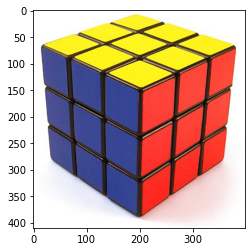

In [131]:
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
rubix = np.array(rubix, dtype=np.float64) / 255

# Let's take a look at the image
plt.imshow(rubix)
plt.show()

In [132]:
# Load image and transform to a 2D numpy array, where each row is for one pixel
w, h, d = original_shape = tuple(rubix.shape)
assert d == 3
image_array = np.reshape(rubix, (w * h, d))

Running $k$-means on all $400\times 410 = 164000$ pixels would take a while. Let's therefore take a sample of the pixels instead and run $k$-means on just these pixels. 

In [133]:
print("Selecting a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:3000]  # Take a random subsample of size 3000

Selecting a small sub-sample of the data


Scikit-learn to fit a k-means model on the subsample with `n_colors = 64`.

In [150]:
from sklearn import linear_model

kmeans = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')
labels = kmeans.fit_predict(image_array_sample)

In [151]:
labels

array([1, 2, 2, ..., 0, 1, 2])

In [152]:
kmeans.cluster_centers_

array([[0.24987758, 0.23377981, 0.37689032],
       [0.9786466 , 0.95977426, 0.96163845],
       [0.97306896, 0.54642873, 0.18155981]])

## Chosen colors

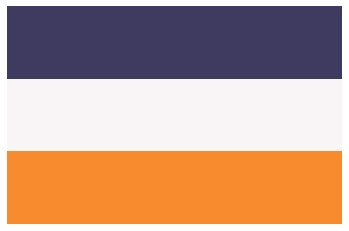

In [153]:
# First recall that each cluster center is just a vector of three numbers:
kmeans.cluster_centers_[0, :]

# Now let's plot the colors that were the cluster centers in k-means.
colors = np.expand_dims(kmeans.cluster_centers_, axis=1)
plt.axis('off')
plt.imshow(colors, aspect='auto')
plt.show()

Now we can assign each pixel in the entire image (not just the pixels we ran $k$-means on) to the nearest cluster center.

In [154]:
# Get labels (nearest cluster means) for all points
print("Predicting color indices on the full image using results from k-means")
t0 = time()
labels = kmeans.predict(image_array)
print("Done in %0.3fs." % (time() - t0))

Predicting color indices on the full image using results from k-means
Done in 0.029s.


Let's see what the image looks like when we recreate it using our $k$-means result. In the recreation, the color of each pixel is going to be the color of the nearest cluster center.

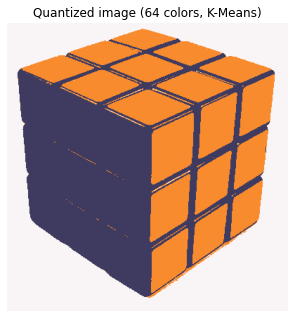

In [155]:
def recreate_image(codebook, labels, w, h):
    """Recreate the compressed image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
plt.show()

If we chose 64 random colors rather than 64 colors resulting from $k$-means.

In [156]:
codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print("Done in %0.3fs." % (time() - t0))

Predicting color indices on the full image (random)
Done in 0.219s.


Here is a side-by-side display of the original image and the two quantized images:

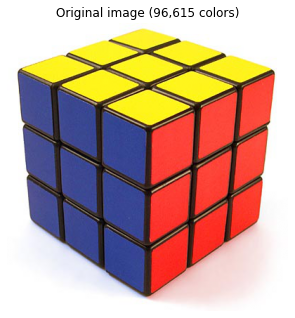

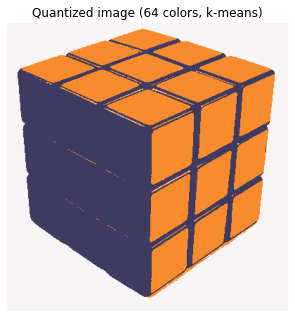

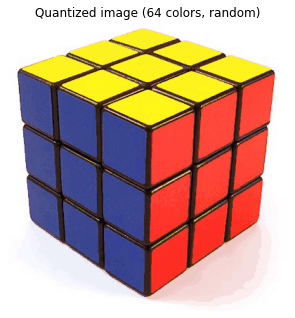

In [157]:
# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(rubix)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, k-means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()